In [1]:
"""
En este paso filtramos el dataset de alumnos por el año 2016 y hacemos join con el dataset de escuelas.
Luego eliminamos NULLs y grabamos el file df_final.csv. Pensando en predecir el campo nivel_desemp_matematica, 
lo transofrmamos en dos categorias, SATIFACTORIO con valor 0 (satifactorio y avanzado) y 1 BÁSICO (básico y por debajo de básico).
Para ejecutar este paso deben tener en la carpeta /desafio3/datasets , los datasets app_alumno.csv y app_escuela.csv.
"""

import pandas as pd
df = pd.read_csv('../desafio3/datasets/app_alumno.csv', parse_dates=True, na_values=['nc'], low_memory=False)
df_escuelas = pd.read_csv('../desafio3/datasets/app_escuela.csv', parse_dates=True, na_values=['nc'], low_memory=False)
df_escuelas = df_escuelas.drop('icse', axis=1)
df_provincia = pd.read_csv('../desafio3/datasets/app_provincia.csv', parse_dates=True, na_values=['nc'], low_memory=False)
df_departamento = pd.read_csv('../desafio3/datasets/app_departamento.csv', parse_dates=True, na_values=['nc'], low_memory=False)
df_salario = pd.read_csv('../desafio3/datasets/app_salario.csv', parse_dates=True, na_values=['nc'], low_memory=False)
df_gastonivel = pd.read_csv('../desafio3/datasets/app_gastonivel.csv', parse_dates=True, na_values=['nc'], low_memory=False)
df_gastoobjeto = pd.read_csv('../desafio3/datasets/app_gastoobjeto.csv', parse_dates=True, na_values=['nc'], low_memory=False)


In [2]:
#Nos quedamos con los casos sin nulos en desmpeño de matemática.
#También nos quedamos con el año 2016 y los exámenes de primaria
df = df[(df['nivel_desemp_matematica'].notnull()) & (df['year_id'] == 2016) & (df['nivel_id'] == 2)]

In [3]:
#Identificamos como avanzado y satisfactorio el desmpeño en matematica segun la nota
df['nivel_desemp_matematica'] = df['nivel_desemp_matematica'].apply(lambda x: 0 if x in ['satisfactorio','avanzado'] else 1)

In [4]:
#Eliminamos columnas que no vamos a usar en el modelo y aquellas observaciones que tengan na
df = df.drop(['id','repeticion_secundaria','nivel_desemp_ciencias_sociales','nivel_desemp_ciencias_naturales','year_id', 'nivel_id'], axis=1)
df = df.dropna(axis=0)

In [5]:
#### SE AGREGA JOIN PARA AGREGAR AL DATAFRAME LA CANTIDAD DE ALUMNOS QUE TIENE CADA ESCUELA
df_curso = pd.read_csv('../desafio3/datasets/app_curso.csv', parse_dates=True, na_values=['nc'], low_memory=False)
df_curso = df_curso[df_curso['year_id'] == 2016]
df_curso_gr = df_curso.groupby(by='escuela_id')['matricula'].sum()
df_curso_gr = df_curso_gr.reset_index()
df_escuelas = df_escuelas.rename(columns={'id': 'escuela_id'})
df_escuelas = df_escuelas.merge(df_curso_gr, how='inner', on ='escuela_id')
####

In [6]:
df = df.merge(df_escuelas, how='inner', on ='escuela_id')
df = df.drop('icse_cat', axis=1)
df = df.dropna(axis=0)

In [7]:
df_curso_prov = df_curso.merge(df_escuelas, how = 'inner', on ='escuela_id')

In [8]:
df_curso_prov = df_curso_prov.groupby(by='provincia_id')['matricula_x'].sum()

In [9]:
df_curso_prov = pd.DataFrame(df_curso_prov)
df_curso_prov['id'] = df_curso_prov.index


In [10]:
# Limpieza del dataset de salario
df_salario = df_salario[(df_salario['year_id'] == 2016)]
df_salario = df_salario.groupby(['provincia_id', 'name'])['value'].aggregate('mean').unstack()


In [11]:
# Limpieza del dataset de gasto nivel
df_gastonivel = df_gastonivel[(df_gastonivel['year_id'] == 2016)]
df_gastonivel = df_gastonivel.groupby(['provincia_id', 'name'])['value'].aggregate('mean').unstack()
df_gastonivel = df_gastonivel.merge(df_curso_prov, how='inner', left_on=['provincia_id'],right_on=['id'])
df_gastonivel = df_gastonivel[['inicial+primaria', 'privada', 'secundaria', 'sin_discriminar', 'snu']].div(df_gastonivel.matricula_x, axis=0)
df_gastonivel['provincia_id'] = df_gastonivel.index

In [12]:
# Limpieza del dataset de gasto objeto
df_gastoobjeto = df_gastoobjeto[(df_gastoobjeto['year_id'] == 2016)]
df_gastoobjeto = df_gastoobjeto.groupby(['provincia_id', 'name'])['value'].aggregate('mean').unstack()
df_gastoobjeto = df_gastoobjeto.merge(df_curso_prov, how='inner', left_on=['provincia_id'],right_on=['id'])
df_gastoobjeto = df_gastoobjeto[['bienes_y_servicios_no_personales', 'erogacion_de_capital', 'personal', 'transferencias_educacion_privada', 'transferencias_otras']].div(df_gastoobjeto.matricula_x, axis=0)
df_gastoobjeto['provincia_id'] = df_gastoobjeto.index

In [13]:
# Merge de los dataset limpios

df = df.merge(df_salario, how = 'inner', on = 'provincia_id')
df = df.merge(df_gastonivel, how = 'inner', on = 'provincia_id')
df = df.merge(df_gastoobjeto, how = 'inner', on = 'provincia_id')

In [14]:
ponderador_mate = df.ponderador_matematica
ponderador_lengua = df.ponderador_lengua
df.drop(columns=['ponderador_lengua', 'ponderador_matematica','ponderador_ciencias_naturales', 'ponderador_ciencias_sociales'],inplace = True)
df_ponderadores = pd.concat([ponderador_mate, ponderador_lengua], axis=1)

In [15]:
print('#######SHAPE:','\n',df.shape,'\n','#######','\n')
print('#######VALUE_COUNTS:','\n',df['nivel_desemp_matematica'].value_counts(),'\n','#######','\n')
print('#######NULLs:','\n',(df.isnull().sum()/df.shape[0])*100,'\n','#######','\n')
print('#######BALANCE:','\n',df['nivel_desemp_matematica'].value_counts(),'\n','#######','\n')
df.to_csv('../desafio3/datasets/df_final.csv')
df_ponderadores.to_csv('../desafio3/datasets/df_ponderadores.csv')

#######SHAPE: 
 (277573, 42) 
 ####### 

#######VALUE_COUNTS: 
 0    170447
1    107126
Name: nivel_desemp_matematica, dtype: int64 
 ####### 

#######NULLs: 
 sexo                                0.0
indice_socioeconomico               0.0
nivel_desemp_matematica             0.0
nivel_desemp_lengua                 0.0
tiene_notebook                      0.0
tiene_pc                            0.0
tiene_tablet                        0.0
tiene_celular                       0.0
tiene_smartphone                    0.0
tiene_consola                       0.0
tiene_smarttv                       0.0
tiene_cable                         0.0
tiene_internet_x                    0.0
repeticion_primaria                 0.0
escuela_id                          0.0
ambito                              0.0
gestion                             0.0
indice_socioeconomico_medio         0.0
indice_socioeconomico_medio_cat     0.0
tecnica                             0.0
tiene_internet_y                    0.0


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


Bad key "text.kerning_factor" on line 4 in
C:\Users\gbulgach\AppData\Local\Continuum\anaconda3\envs\dhdsblend\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [17]:
"""
En este paso, levantamos el nuevo dataset y aplicamos transformaciones, one hot enconder para las columnas categoricas y scalar para las numericas. Al terminar las transformaciones aplicamos RFE para eliminar features, el resultado de este paso se guarda como matriz esparsa en un file.
En el siguiente paso se debera levantar la X y Y de files como se indica a continaucion:

y = pd.read_csv('../desafio3/datasets/df_final.csv', parse_dates=True, na_values=['nc'], low_memory=False)
y = y['nivel_desemp_matematica']
X = scipy.sparse.load_npz('../desafio3/datasets/sparse.npz')

"""
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
import scipy.sparse
from sklearn.model_selection import RandomizedSearchCV


df = pd.read_csv('../desafio3/datasets/df_final.csv', parse_dates=True, na_values=['nc'], low_memory=False)

df = df.drop('Unnamed: 0', axis=1)
for i in df.columns:
    if (df[i].dtype == object) or i in ['nivel_id', 'escuela_id', 'provincia_id', 'departamento_id']:
        df[i] = pd.Categorical(df[i])

X = df.drop('nivel_desemp_matematica', axis=1)
y = df['nivel_desemp_matematica']
folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns = 'n'):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            #c para tomar columnas categoricas, cualquier otro valor para tomar continuas.
            if self.columns == 'c':
                categorical_columns = [col for col in X.columns if pd.api.types.is_categorical_dtype(df[col])]
                return pd.DataFrame(X[categorical_columns])
            else:
                scal_columns = [col for col in X.columns if (pd.api.types.is_categorical_dtype(df[col]) == False)]
                return pd.DataFrame(X[scal_columns])
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self
cat_pipe = make_pipeline(ColumnSelector('c'),OneHotEncoder(handle_unknown='error',drop = 'first'))
num_pipe = make_pipeline(ColumnSelector('n'),RobustScaler())
union = make_union(num_pipe,
                   cat_pipe)
            
lr = LogisticRegression()
rfe = RFECV(lr,step=2000, cv=folds, n_jobs=5) 
df_union = rfe.fit_transform(union.fit_transform(X), y)
scipy.sparse.save_npz('../desafio3/datasets/sparse.npz',df_union)


C:\Users\gbulgach\AppData\Local\Continuum\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\gbulgach\AppData\Local\Continuum\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver

In [18]:
X = scipy.sparse.load_npz('../desafio3/datasets/sparse.npz')
print("SHAPE MATRIZ ESPARZA: ",X.shape)

SHAPE MATRIZ ESPARZA:  (277573, 7014)


In [ ]:
#Analisis descriptivo

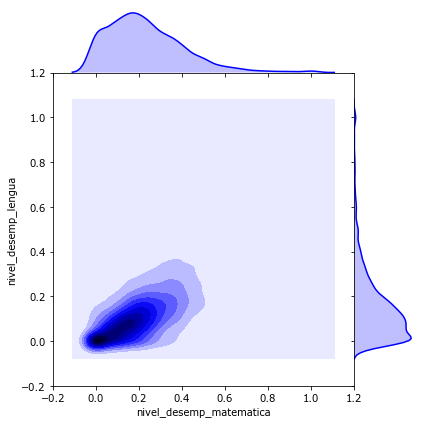

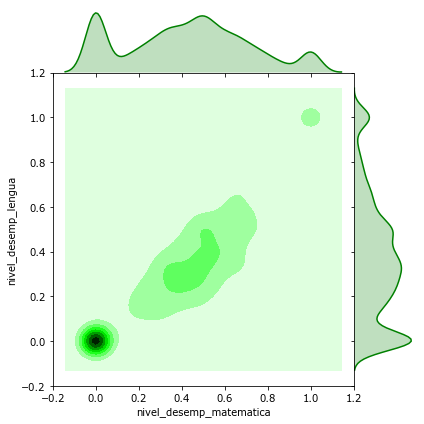

In [19]:
#Diferencias de resultados en examenes de matematica y lengua por clase de escuela

df['nivel_desemp_lengua'] = df['nivel_desemp_lengua'].apply(lambda x: 0 if x in ['satisfactorio','avanzado'] else 1)

tabla_escuelas_matematica = df.groupby(['escuela_id'])['nivel_desemp_matematica'].mean()
tabla_escuelas_lengua = df.groupby(['escuela_id'])['nivel_desemp_lengua'].mean()

tabla_escuelas = pd.concat([tabla_escuelas_lengua, tabla_escuelas_matematica], axis = 1)

tabla_escuelas = tabla_escuelas.merge(df_escuelas, how = 'inner', on = 'escuela_id')
tabla_escuelas_privada = tabla_escuelas[(tabla_escuelas['gestion'] == 'privada')]
tabla_escuelas_estatal = tabla_escuelas[(tabla_escuelas['gestion'] == 'estatal')]



sns.jointplot('nivel_desemp_matematica', 'nivel_desemp_lengua', data=tabla_escuelas_privada, kind="kde", xlim = [-0.2, 1.2], ylim = [-0.2, 1.2], space=0, color="b")
sns.jointplot('nivel_desemp_matematica', 'nivel_desemp_lengua', data=tabla_escuelas_estatal, kind="kde", xlim = [-0.2, 1.2], ylim = [-0.2, 1.2], space=0, color="g")


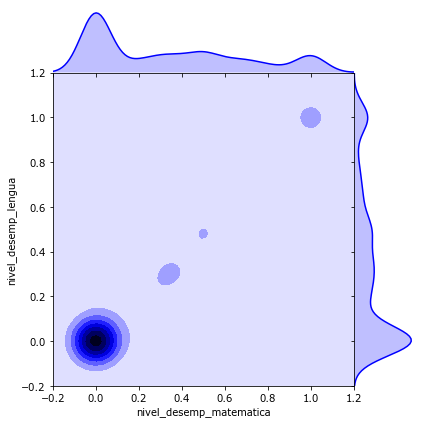

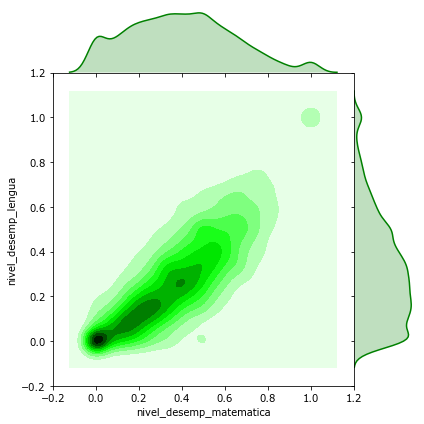

In [20]:
#Diferencias de resultados en examenes de matematica y lengua por ambito de escuela

tabla_escuelas_rural = tabla_escuelas[(tabla_escuelas['ambito'] == 'rural')]
tabla_escuelas_urbano = tabla_escuelas[(tabla_escuelas['ambito'] == 'urbano')]

sns.jointplot('nivel_desemp_matematica', 'nivel_desemp_lengua', data=tabla_escuelas_rural, kind="kde", xlim = [-0.2, 1.2], ylim = [-0.2, 1.2], space=0, color="b")
sns.jointplot('nivel_desemp_matematica', 'nivel_desemp_lengua', data=tabla_escuelas_urbano, kind="kde", xlim = [-0.2, 1.2], ylim = [-0.2, 1.2], space=0, color="g")

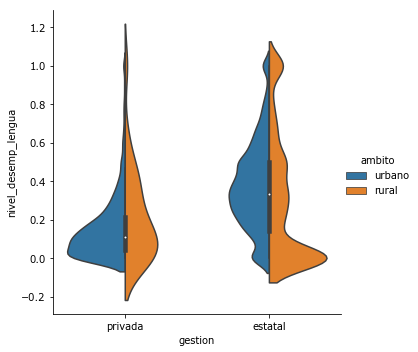

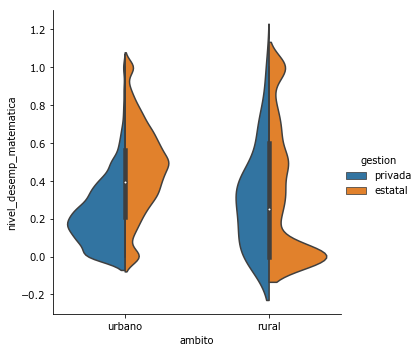

In [21]:
#Resultados por escuela por ambito y por gestion
tabla_escuelas_2 = tabla_escuelas[(tabla_escuelas['gestion'] != 'social/cooperativa')]

sns.catplot(x="gestion", y="nivel_desemp_lengua",
            hue="ambito",
            data=tabla_escuelas_2, kind="violin", split=True,
            height=5, aspect=1);

sns.catplot(x="ambito", y="nivel_desemp_matematica",
            hue="gestion",
            data=tabla_escuelas_2, kind="violin", split=True,
            height=5, aspect=1);

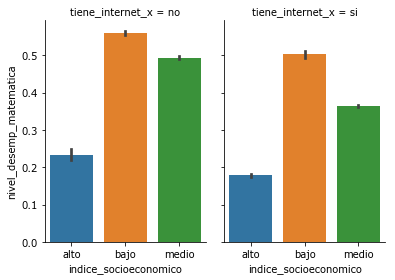

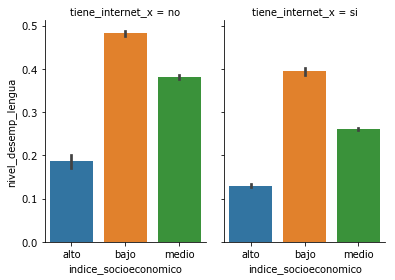

In [22]:
#Resultados por alumno en cada materia

df.groupby(['indice_socioeconomico'])['nivel_desemp_matematica'].mean()

df.indice_socioeconomico.value_counts()

sns.catplot(x="indice_socioeconomico", y="nivel_desemp_matematica",
            col="tiene_internet_x",
            data=df, kind="bar",
            height=4, aspect=.7);

sns.catplot(x="indice_socioeconomico", y="nivel_desemp_lengua",
            col="tiene_internet_x",
            data=df, kind="bar",
            height=4, aspect=.7);

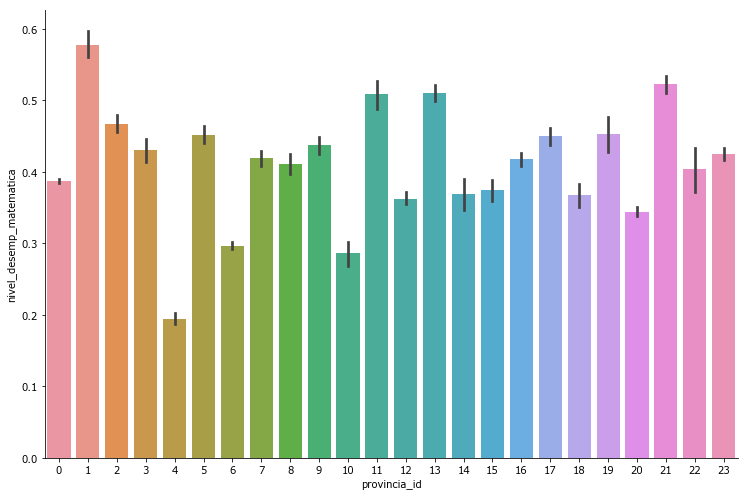

In [23]:
#Que provincia tiene mayor ponderacion de aprobados
sns.catplot(x="provincia_id", y="nivel_desemp_matematica",
            data=df, kind="bar",
            height=7, aspect=1.5);

[Text(0,0.5,'Cantidad de Alumnos'), Text(0.5,0,'Desempeño Matemática')]

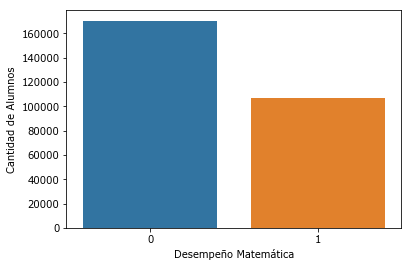

In [24]:
#Porcentaje de satisfactorio
ax = sns.countplot(x="nivel_desemp_matematica", data=df)
ax.set(xlabel='Desempeño Matemática', ylabel='Cantidad de Alumnos')